In [1]:
import numpy as np

In [69]:
x = np.random.randn(10,5,10)

In [70]:
xu, xs, xv = np.linalg.svd(x.reshape(10, 50), False)

In [71]:
len(xs)

10

In [72]:
delta = 0.1 * np.linalg.norm(x)

In [73]:
xs_list = list(xs * xs)
xs_list.reverse()

In [74]:
np.cumsum(xs_list)

array([ 19.91980028,  42.31974494,  72.00174746, 102.96931833,
       143.01357806, 198.49217203, 261.43030127, 333.05622813,
       410.93516719, 514.44120308])

In [75]:
delta = 0.5 * np.linalg.norm(x)
delta ** 2

np.float64(128.6103007688906)

In [76]:
y = np.diag(xs)@xv
y = y.reshape(10, 5, 10).reshape(50, 10)
yu, ys, yv = np.linalg.svd(y, False)

In [77]:
ys

array([9.42445547, 8.60140345, 8.46341856, 8.11418914, 7.87489602,
       6.34708836, 6.01524307, 5.62788447, 4.93255011, 4.4363702 ])

In [78]:
y1 = np.diag(xs[:9]) @ xv[:9]
y1 = y1.reshape(9,5,10).reshape(45, 10)
y1u, y1s, y1v = np.linalg.svd(y1, False)

In [83]:
sum(y1s ** 2)

np.float64(494.5214027952504)

In [80]:
y2 = np.diag(xs[:8]) @ xv[:8]
y2 = y2.reshape(8,5,10).reshape(40, 10)
y2u, y2s, y2v = np.linalg.svd(y2, False)

In [85]:
print(sum(y2s ** 2) - sum(y1s ** 2), xs[8] ** 2)

-22.39994465682429 22.39994465682396


In [88]:
(y2s ** 2) - (y1s ** 2)

array([-2.77522989, -0.91772289, -0.77935616, -1.48696799, -2.07726949,
       -4.91076268, -1.53423529, -4.12996343, -1.90248267, -1.88595416])

In [31]:
xxu, xxs, xxv = np.linalg.svd(x.reshape(50, 10), False)

In [32]:
xxs

array([10.27440391,  8.80359285,  7.86556037,  7.29924234,  6.81819071,
        6.48158369,  6.19179624,  5.97844581,  4.9486264 ,  4.46473037])

In [49]:
# prototype for TT
x = np.random.randn(10, 5, 10)
delta = (0.5 * np.linalg.norm(x)) ** 2

x_u, x_s, x_v = np.linalg.svd(x.reshape(10, 50), False)
x_s_list = list(x_s * x_s)
x_s_list.reverse()
x_cut = [i for i in np.cumsum(x_s_list) if i <= delta]
x_rank = max(1, len(x_s) - len(x_cut))
x_delta = delta - x_cut[-1] if len(x_cut) > 0 else delta

# divide tt1 into two parts, truncation and residual
x_residual_u, x_residual_s, x_residual_v = x_u[:, :x_rank], x_s[:x_rank], x_v[:x_rank]
x_truncate_u, x_truncate_s, x_truncate_v = x_u[:, x_rank:], x_s[x_rank:], x_v[x_rank:]

y_residual = np.diag(x_residual_s) @ x_residual_v
y_truncate = np.diag(x_truncate_s) @ x_truncate_v

# simultaneously truncate the second part
y_residual_u, y_residual_s, y_residual_v = np.linalg.svd(y_residual.reshape(x_rank, 5, 10).reshape(5 * x_rank, 10), False)
y_residual_s_list = list(y_residual_s ** 2)
y_residual_s_list.reverse()
y_residual_cut = [i for i in np.cumsum(y_residual_s_list) if i <= x_delta]
y_residual_rank = max(1, len(y_residual_s) - len(y_residual_cut))
y_delta = x_delta - y_residual_cut[-1] if len(y_residual_cut) > 0 else x_delta

y_residual_residual_u, y_residual_residual_s, y_residual_residual_v = y_residual_u[:, :y_residual_rank], y_residual_s[:y_residual_rank], y_residual_v[:y_residual_rank]
y_residual_truncate_u, y_residual_truncate_s, y_residual_truncate_v = y_residual_u[:, y_residual_rank:], y_residual_s[y_residual_rank:], y_residual_v[y_residual_rank:]

y_truncate_u, y_truncate_s, y_truncate_v = np.linalg.svd(y_truncate.reshape(10 - x_rank, 5, 10).reshape(5 * (10 - x_rank), 10), False)

In [50]:
print("x rank", x_rank)
print("y_residual rank", y_residual_rank)

x rank 6
y_residual rank 9


In [68]:
print(delta, x_delta, y_delta)
# Do we have better error distribution?
# If we would like the x_rank to increase and y_rank to decrease
# we have two variables x and y
x_cut.reverse()
print(x_cut)
x_used_delta = [delta - x_delta] + [delta - x_delta - i for i in x_cut]
y_used_delta = [x_delta - y_delta] + [x_delta - y_delta + i for i in np.cumsum(y_residual_s_list[len(y_residual_cut):])]
# We need to choose proper x and y so that 10 * x + 5 * x * y + 10 * y is minimized
# Naive solver, consider all possible values for x and y
best_cost = 10 * x_rank + 5 * x_rank * y_residual_rank + 10 * y_residual_rank
best_ranks = None
for x in range(len(x_s) - x_rank):
  for y in range(y_residual_rank):
    # print(x, y)
    if x_used_delta[x] + y_used_delta[y] <= delta:
        cost = 10 * (x + x_rank) + 5 * (x + x_rank) * (y_residual_rank - y) + 10 * (y_residual_rank - y)
        print(cost)
        if cost < best_cost:
           best_cost = cost
           best_ranks = (x, y)

print(best_ranks)

122.43054530574081 7.0252113069868045 1.8086136412677964
[np.float64(115.405333998754), np.float64(80.91250892571054), np.float64(49.24406256391087), np.float64(21.938619228995485)]
420
475
430
385
340
295
530
480
430
380
585
530
475
(1, 4)


In [1]:
import numpy as np

In [2]:
x = np.random.randn(4,5)
xu, xs, xv = np.linalg.svd(x)
print(xs)

[3.55104197 1.65567968 1.35505927 0.67131149]


In [3]:
xu = xu[:,:2]
xv = xv[:2]
xs = xs[:2]
y = xu @ np.diag(xs) @ xv

In [4]:
yu, ys, yv = np.linalg.svd(y)
ys

array([3.55104197e+00, 1.65567968e+00, 2.90743841e-16, 1.02171449e-16])

In [8]:
xvu, xvs, xvv = np.linalg.svd(xv)
yy = xu @ np.diag(xs) @ xvu[:,:1]

In [9]:
yyu, yys, yyv = np.linalg.svd(yy)
yys

array([3.55104197])

In [10]:
svu, svs, svv = np.linalg.svd(np.diag(xs) @ xv)
svs

array([3.55104197, 1.65567968])

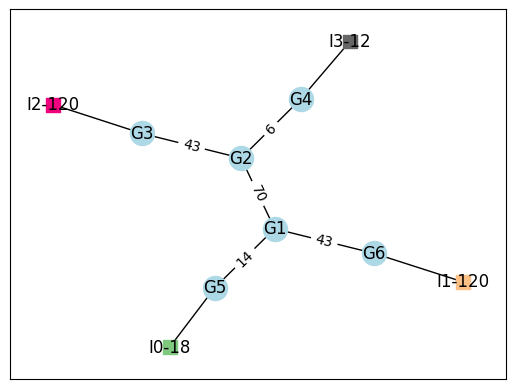

In [19]:
from pytens.algs import *
from benchmarks.benchmark import *
import json

with open("benchmarks/BigEarthNet-v1_0_stack/stack_18_test_2/ht_010.json") as json_file:
  bd = json.load(json_file)

benchmark = Benchmark(**bd)
net = benchmark.to_network()

net.compress()
net.draw()

import matplotlib.pyplot as plt

plt.show()

In [224]:
import numpy as np
target_tensor = np.load("data/BigEarthNet-v1_0_stack/stack_18_test_2/data.npy").astype(np.float32)

In [3]:
from pytens.search.search import *

engine = SearchEngine({"eps": 0.1, "beam_size": 50, "max_ops": 6, "no_heuristic": False, "prune": False, "consider_ranks": False, "split_errors": 0, "guided": False, "start_from": ["core", "ht"], "verbose": True})
engine.beam(net, target_tensor)

{'split': 2098,
 'merge': 992,
 'split time': 9.894572734832764,
 'count': 2694,
 'compression': [(0.0033359527587890625, 1.090041851304776),
  (0.006696939468383789, 1.2577718597425656),
  (0.010377883911132812, 1.1370698510529018),
  (0.013307809829711914, 1.0929005584523772),
  (0.015830039978027344, 1.0924623735504564),
  (0.019189119338989258, 1.0239939870490287),
  (0.021937847137451172, 1.0131861216784417),
  (0.024435997009277344, 1.0),
  (0.026855945587158203, 0.9981402164111812),
  (0.029623746871948242, 1.0108297067846186),
  (0.030338764190673828, 0.8573434020718366),
  (0.031128883361816406, 0.5019271099019441),
  (0.03220486640930176, 0.4268739455290431),
  (0.032750844955444336, 0.7227209662939689),
  (0.03339195251464844, 0.7975054034582133),
  (0.03987383842468262, 1.297414108856494),
  (0.04183793067932129, 1.330104014118884),
  (0.04452109336853027, 1.3191568598242216),
  (0.04686903953552246, 1.4094381664809805),
  (0.04951596260070801, 1.2323267464514334),
  (0.055

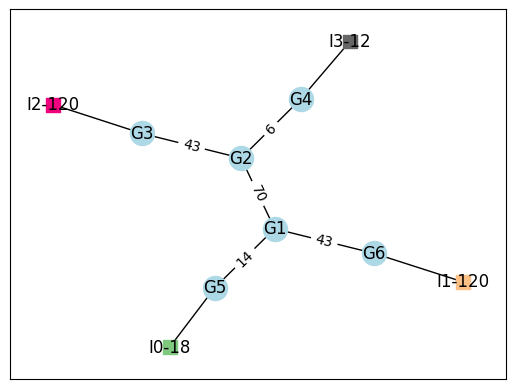

In [4]:
net.draw()

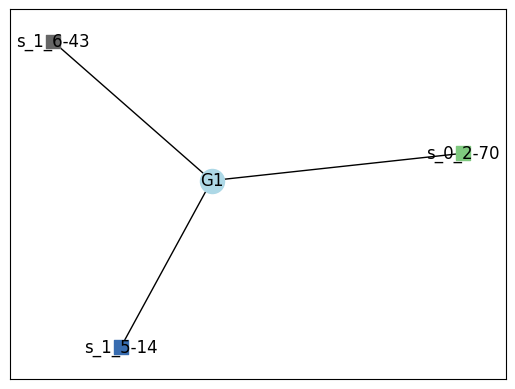

In [21]:
# separate out the node G1
g1_net = TensorNetwork()
g1_net.add_node("G1", net.network.nodes["G1"]["tensor"])
g1_net.draw()

In [225]:
params = {"eps": 0.1, "beam_size": 50, "max_ops": 6, "no_heuristic": False, "prune": False, "consider_ranks": False, "split_errors": 5, "guided": False, "start_from": ["core", "ht"], "verbose": True}
engine = BeamSearch(params)
delta = np.sqrt((params["eps"] * np.linalg.norm(target_tensor)) ** 2 - np.linalg.norm(net.contract().value.squeeze() - target_tensor) ** 2)
g1_search_state = SearchState(g1_net, delta)
g1_stats = engine.search(g1_search_state, guided=False)

In [249]:
delta = np.sqrt((params["eps"] * np.linalg.norm(target_tensor)) ** 2 - np.linalg.norm(net.contract().value.squeeze() - target_tensor) ** 2)


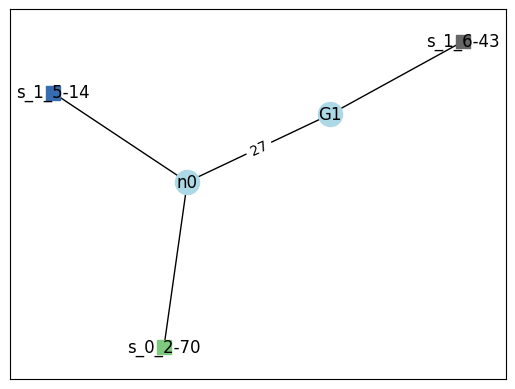

In [23]:
engine.best_network.draw()

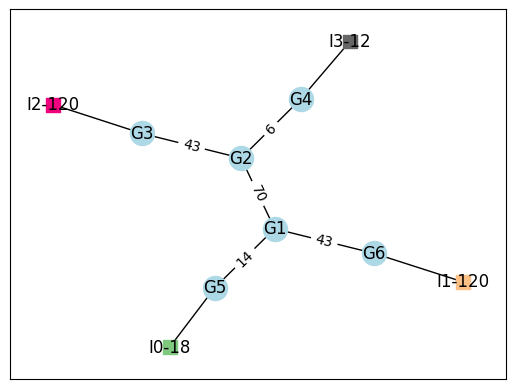

In [250]:
net.draw()

In [251]:
net_val = net.contract().value
print(delta ** 2 + np.linalg.norm(net_val - target_tensor) ** 2, (0.1 * np.linalg.norm(target_tensor)) ** 2)

195717320000.0 195717320000.0


In [287]:
import copy
tmp_net = copy.deepcopy(net)
_, rd = tmp_net.delta_split("G1", [0,2], [1], delta=delta)
# u,s,v = tmp_net.split("G1", [0,2], [1])

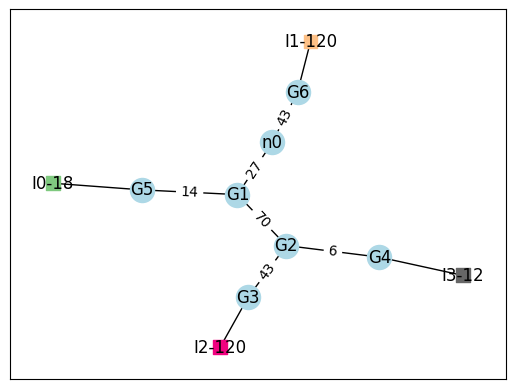

In [288]:
tmp_net.draw()

In [267]:
s_vals = np.cumsum(np.flip(np.diag(tmp_net.network.nodes[s]["tensor"].value)) ** 2) 
s_vals

KeyError: 'n1'

In [261]:
s_vals[s_vals < delta ** 2]

array([1.0094146e+09, 2.1242819e+09, 3.4025728e+09, 4.9975204e+09,
       6.7782385e+09, 8.6568858e+09, 1.0865288e+10, 1.3428027e+10,
       1.6035568e+10, 1.8984401e+10, 2.2652649e+10, 2.6816582e+10,
       3.1221375e+10, 3.6026724e+10, 4.0898494e+10, 4.6458241e+10],
      dtype=float32)

In [289]:
tmp_val = tmp_net.contract().value
print(np.linalg.norm(target_tensor), tmp_net.norm(), np.linalg.norm(tmp_val), net.norm(), np.linalg.norm(net_val))
print(np.linalg.norm(target_tensor - tmp_val) / np.linalg.norm(target_tensor))
print(np.linalg.norm(tmp_val - target_tensor) ** 2 + rd ** 2, np.linalg.norm(net_val - target_tensor) ** 2 + delta ** 2, (0.1 * np.linalg.norm(target_tensor)) ** 2)
print(s_vals[-1], np.linalg.norm(target_tensor) ** 2)

4423995.0 4402134.196591467 4402116.0 4407402.586071756 4407389.0
0.0993158
195716990000.0 195717320000.0 195717320000.0
19378815000000.0 19571732000000.0


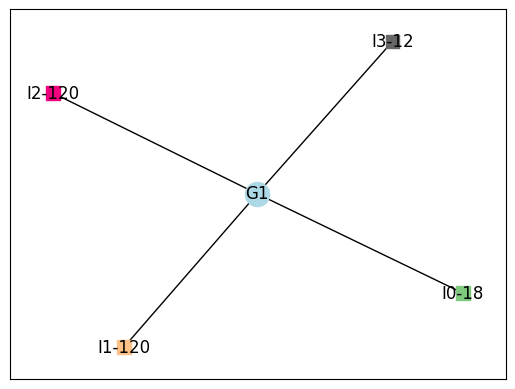

In [301]:
ttmp_net = copy.deepcopy(tmp_net)
ttmp_net.merge("n0", "G6")
ttmp_net.merge("G1", "G5")
ttmp_net.merge("G1", "n0")
ttmp_net.merge("G2", "G4")
ttmp_net.merge("G1", "G2")
ttmp_net.merge("G1", "G3")
ttmp_net.draw()

In [302]:
ttmp_val = ttmp_net.contract().value
print(np.linalg.norm(target_tensor - ttmp_val) ** 2, (0.1 * np.linalg.norm(target_tensor)) ** 2 - rd ** 2)

193048280000.0 193048610000.0


In [303]:
ttmp_net.network.nodes["G1"]["tensor"].indices

[Index(name='I0', size=18),
 Index(name='I1', size=120),
 Index(name='I3', size=12),
 Index(name='I2', size=120)]

In [304]:
g1_val = ttmp_net.network.nodes["G1"]["tensor"].value
g1_val_reshaped = g1_val.transpose(1,3,0,2).reshape(g1_val.shape[1] * g1_val.shape[3], g1_val.shape[0] * g1_val.shape[2])
# averages along the columns and rows
print(g1_val_reshaped.sum(axis=0))
print(g1_val_reshaped.sum(axis=1))

[ 5594914.5   6061567.5  10023036.    8283990.   15874140.   39795300.
 48285596.   51908132.   52185592.   52139584.   29588316.   16951550.
 82516016.   82274304.   76854600.   80230840.   84342880.   85951808.
 84519760.   89830192.   83858792.   83276456.    8938604.    9344953.
 45976744.   46667164.   44522784.   45919104.   49022364.   55281264.
 56434956.   60838960.   56858500.   57613648.    9967116.    7710853.
  8570233.   10045275.   14280268.   16230273.   23958184.   35733416.
 40131288.   41763520.   44451676.   43939432.   44696672.   31415446.
  2126400.2   3282333.8   6518944.    5552669.5  11230910.   28151268.
 34159976.   36502460.   37103776.   36555272.   22702850.   13285478.
  1260328.4   1971066.8   3814500.    3404662.8   6626256.5  15749905.
 18988788.   20179096.   20660392.   20537586.   13163355.    7867706.5
  9794002.   12205533.   14184506.   16227000.   19869326.   23756838.
 25147920.   26719966.   27354218.   26329096.   25785012.   19004678.
   97

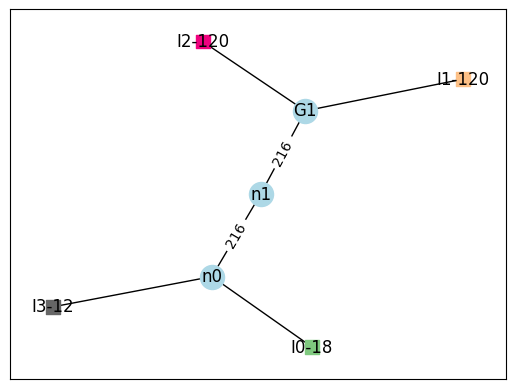

In [305]:
u,s,v = ttmp_net.split("G1", [1,3], [0,2])
ttmp_net.draw()

In [299]:
print(np.diag(ttmp_net.network.nodes[s]["tensor"].value))
s_vals = np.cumsum(np.flip(np.diag(ttmp_net.network.nodes[s]["tensor"].value)) ** 2) 
print(s_vals[150:-50], rd**2, (0.1 * np.linalg.norm(target_tensor)) ** 2 - np.linalg.norm(target_tensor - ttmp_val) ** 2)

[4.02625275e+06 1.15119538e+06 8.93149812e+05 6.66620562e+05
 3.32135656e+05 2.78777344e+05 2.25372969e+05 2.05918141e+05
 1.92063953e+05 1.75163938e+05 1.65926984e+05 1.53994688e+05
 1.50977938e+05 1.45433969e+05 1.40663875e+05 1.39153812e+05
 1.21947797e+05 1.13775406e+05 1.08807625e+05 9.79071484e+04
 9.61057891e+04 8.94791641e+04 7.80964922e+04 7.24043047e+04
 6.67484375e+04 6.13395273e+04 5.72135078e+04 5.01125508e+04
 4.72326719e+04 4.44277070e+04 4.17924648e+04 3.84421328e+04
 3.66423672e+04 3.54955820e+04 3.48474570e+04 3.40982539e+04
 3.25442246e+04 3.14878633e+04 3.02802070e+04 2.79914199e+04
 2.75354492e+04 2.69280605e+04 2.56723145e+04 2.50480566e+04
 2.38867402e+04 2.28807793e+04 2.17354785e+04 2.06989980e+04
 2.04589609e+04 1.96022871e+04 1.88390801e+04 1.80474961e+04
 1.78757500e+04 1.76296758e+04 1.66789531e+04 1.58422783e+04
 1.53591445e+04 1.52171484e+04 1.41847695e+04 1.37315137e+04
 1.30329727e+04 1.24643018e+04 1.16088545e+04 1.04942344e+04
 9.37466406e+03 8.870447

In [217]:
ttmp_val = ttmp_net.contract().value
print(np.linalg.norm(target_tensor - ttmp_val) ** 2, (0.1 * np.linalg.norm(target_tensor)) ** 2 - rrd ** 2)

192872150000.0 195518907593.20898


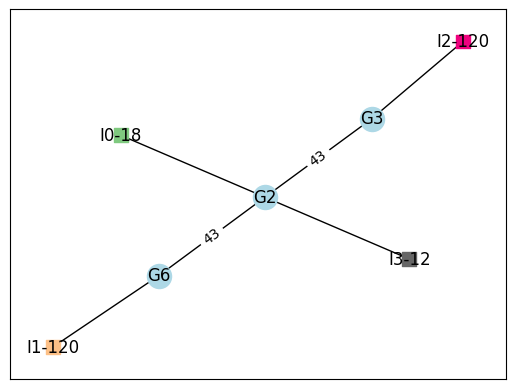

In [147]:
ttmp_net.merge("G1", "G5")
ttmp_net.merge("G2", "G4")
ttmp_net.merge("G2", "G1")
ttmp_net.draw()

In [148]:
ttmp_net.network.nodes["G2"]["tensor"].indices

[Index(name='s_2_3', size=43),
 Index(name='I3', size=12),
 Index(name='s_1_6', size=43),
 Index(name='I0', size=18)]

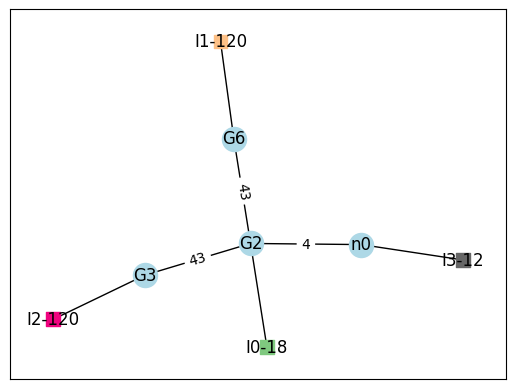

In [149]:
_, rd = ttmp_net.delta_split("G2", [0,2,3], [1], delta=delta)
ttmp_net.draw()

In [150]:
ttmp_net.network.nodes["G2"]["tensor"].indices

[Index(name='s_0', size=43),
 Index(name='s_1', size=43),
 Index(name='I0', size=18),
 Index(name='s_2', size=4)]

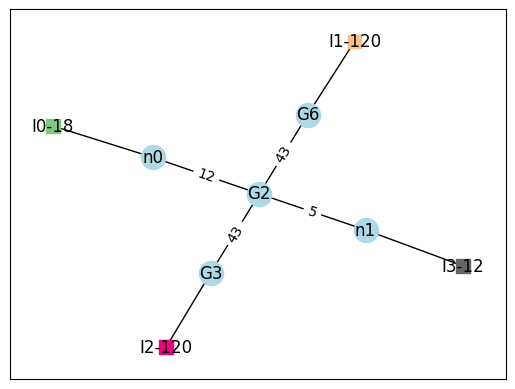

In [133]:
_, rrd = ttmp_net.delta_split("G2", [0,2,3], [1], delta=rrd)
ttmp_net.draw()

In [151]:
ttmp_net.merge("G2", "n0")

'G2'

In [152]:
ttmp_net.network.nodes["G2"]["tensor"].indices

[Index(name='s_0', size=43),
 Index(name='s_1', size=43),
 Index(name='I0', size=18),
 Index(name='I3', size=12)]

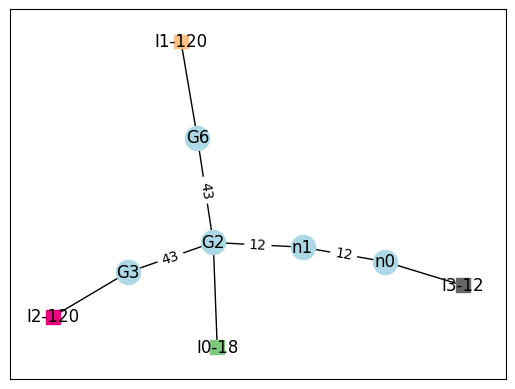

In [153]:
u, s, v = ttmp_net.split("G2", [0,1,2], [3])
ttmp_net.draw()


In [154]:
s_vals = np.cumsum(np.flip(np.diag(ttmp_net.network.nodes[s]["tensor"].value))) ** 2

In [155]:
s_vals

array([5.60967543e-04, 3.48596554e-03, 1.00693107e-02, 2.07696483e-02,
       3.75921428e-02, 6.28993288e-02, 1.04144804e-01, 1.61573872e-01,
       1.02859457e+11, 7.59311630e+11, 4.72660627e+12, 4.01279046e+13],
      dtype=float32)

In [156]:
rd ** 2

37404066514.77004

In [157]:
utensor = ttmp_net.network.nodes[u]["tensor"]
ttmp_net.network.nodes[u]["tensor"].update_val_size(utensor.value[...,:8])
stensor = ttmp_net.network.nodes[s]["tensor"]
ttmp_net.network.nodes[s]["tensor"].update_val_size(stensor.value[:8,:8])
vtensor = ttmp_net.network.nodes[v]["tensor"]
ttmp_net.network.nodes[v]["tensor"].update_val_size(vtensor.value[:8,...])
ttmp_net.merge(v, s)


'n0'

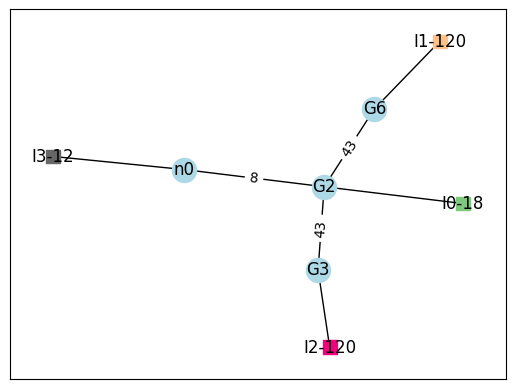

In [158]:
ttmp_net.draw()

In [159]:
rrd = np.sqrt(rd ** 2 - s_vals[4])
print(rd, rrd)

193401.30949600638 193401.31


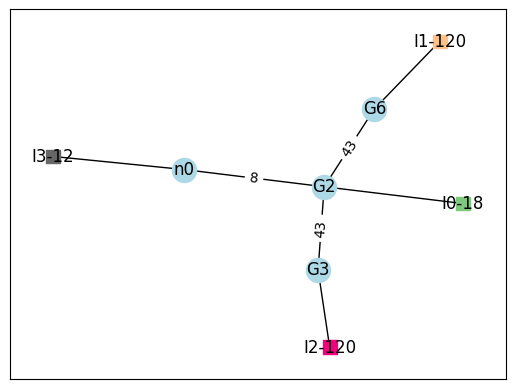

In [163]:
tttmp_net = copy.deepcopy(ttmp_net)
# tttmp_net.merge("G2", "G1")
# tttmp_net.merge("G2", "G5")
# tttmp_net.merge("G2", "G3")
tttmp_net.draw()

In [164]:
tttmp_net.network.nodes["G2"]["tensor"].indices

[Index(name='s_2', size=43),
 Index(name='s_0', size=43),
 Index(name='I0', size=18),
 Index(name='s_3', size=8)]

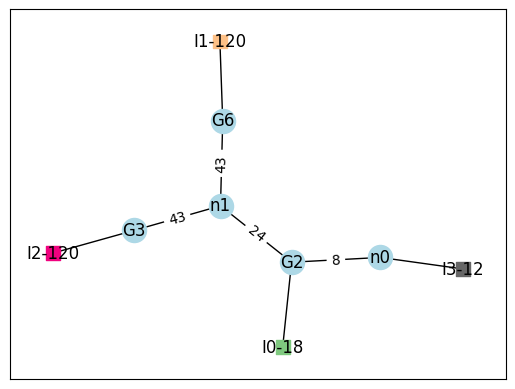

In [165]:
tttmp_net.delta_split("G2", [2,3], [0,1], delta=rrd)
tttmp_net.draw()

In [306]:
x = np.random.randn(4,5,6)

In [311]:
xu, xs, xv = np.linalg.svd(x.reshape(4, 30), False, True)

In [312]:
xs

array([6.94279462, 5.62943617, 4.64741822, 3.20729132])

In [315]:
y = np.diag(xs) @ xv
print(y)
yu, ys, yv = np.linalg.svd(y.reshape(4, 5, 6).reshape(20, 6), False, True)
ys

[[ 0.58208452  0.98362336  0.79637559 -1.5912426   1.3536414   0.24463865
   0.96106757  0.90575415  0.4182699   1.19596881  1.17979936 -2.38144233
  -0.93220416  1.27091248  0.33764383 -0.17214793  2.22947129 -2.23659868
  -0.25800479 -0.96661018  0.36879209  1.33083269  1.69810521  0.17743139
  -1.42838283  0.81921088  2.2622132   1.96366188 -0.97506986  0.60457077]
 [ 2.06156535 -0.07653533 -0.87468479 -0.15453337  2.34557065 -0.30520618
   0.12403974  0.26961544 -0.08323153 -1.12510146  0.09229802  1.51805093
  -0.09735804 -0.81415868  1.44893278  0.3119133   0.1643397  -0.92569927
   2.31790891 -0.48025546 -0.18536218 -0.29702937  1.06436106 -1.4080568
  -0.03872258 -1.07488565 -0.03222841 -1.38060768 -1.23573844  0.4376733 ]
 [-0.26132623 -1.54646992 -0.21459511  0.53923985  1.32228038 -0.1334992
  -0.52649658 -0.45997369 -0.90242088 -0.25441602  0.94914515 -1.845342
  -0.72435925 -0.1569232  -0.79541649  0.80985174  0.30597192 -0.08573191
   0.47919705 -1.3421853  -0.87772651  0

array([6.2934598 , 4.92885821, 4.36491223, 3.42599109, 3.19324939,
       2.62491286])

In [317]:
yy = np.diag(xs[:3])@ xv[:3]
print(yy)
yyu, yys, yyv = np.linalg.svd(yy.reshape(3, 5, 6).reshape(15, 6), False, True)
yys

[[ 0.58208452  0.98362336  0.79637559 -1.5912426   1.3536414   0.24463865
   0.96106757  0.90575415  0.4182699   1.19596881  1.17979936 -2.38144233
  -0.93220416  1.27091248  0.33764383 -0.17214793  2.22947129 -2.23659868
  -0.25800479 -0.96661018  0.36879209  1.33083269  1.69810521  0.17743139
  -1.42838283  0.81921088  2.2622132   1.96366188 -0.97506986  0.60457077]
 [ 2.06156535 -0.07653533 -0.87468479 -0.15453337  2.34557065 -0.30520618
   0.12403974  0.26961544 -0.08323153 -1.12510146  0.09229802  1.51805093
  -0.09735804 -0.81415868  1.44893278  0.3119133   0.1643397  -0.92569927
   2.31790891 -0.48025546 -0.18536218 -0.29702937  1.06436106 -1.4080568
  -0.03872258 -1.07488565 -0.03222841 -1.38060768 -1.23573844  0.4376733 ]
 [-0.26132623 -1.54646992 -0.21459511  0.53923985  1.32228038 -0.1334992
  -0.52649658 -0.45997369 -0.90242088 -0.25441602  0.94914515 -1.845342
  -0.72435925 -0.1569232  -0.79541649  0.80985174  0.30597192 -0.08573191
   0.47919705 -1.3421853  -0.87772651  0

array([6.1443251 , 4.87828938, 3.95341252, 3.21012898, 2.87236693,
       2.39919074])

In [2]:
x = np.random.randn(4,5,6,7)

In [8]:
u1, s1, v1 = np.linalg.svd(x.reshape(4, -1))
s1

array([17.04312444, 15.72398066, 14.68911908, 13.84685063])

In [10]:
u2, s2, v2 = np.linalg.svd(x.transpose(1,0,2,3).reshape(5, -1))
s2

array([15.94737561, 14.44234795, 13.43961141, 12.55115964, 12.00675576])

In [11]:
u3, s3, v3 = np.linalg.svd(x.reshape(20, -1))
s3

array([10.87767414,  9.81752283,  9.60063973,  9.21032914,  8.49475233,
        8.02712117,  7.76283036,  7.53649355,  7.19400922,  6.74105254,
        6.28876802,  5.37350178,  5.18062712,  4.97389234,  4.53101211,
        4.20671   ,  3.93183054,  3.51679217,  3.13555107,  2.60171665])

In [27]:
s_map = {}
for i, s1i in enumerate(s1):
  for j, s2j in enumerate(s2):
    k = i+j
    if k not in s_map:
      s_map[k] = []

    s_map[k].append(s1i * s2j)

print(np.linalg.norm(x)**2, np.sum([s**2 for s in s1]))
results = []
for k, s3k in enumerate(s3):
  print(s3k)
  if k in s_map:
    ss = [s / np.linalg.norm(x) for s in s_map[k]]
    results.extend(ss)
    print(ss)

  print("=======")

print([s1i * s2j / np.linalg.norm(x) for s1i in s1 for s2j in s2])
print(np.sum([(s1i * s2j / np.linalg.norm(x)) ** 2 for s1i in s1 for s2j in s2]))
print(np.sum([s ** 2 for s in results]))

945.217150130424 945.217150130424
10.877674138674324
[np.float64(8.840414777550123)]
9.817522834199766
[np.float64(8.006103911366417), np.float64(8.15616359088748)]
9.600639726599079
[np.float64(7.450237719140501), np.float64(7.386428676692076), np.float64(7.61937201165122)]
9.210329135593362
[np.float64(6.957725197870136), np.float64(6.873586721589301), np.float64(6.900296603678309), np.float64(7.182480146322494)]
8.494752325913643
[np.float64(6.655935349538807), np.float64(6.419194841217059), np.float64(6.421206943991211), np.float64(6.504636246119632)]
8.027121173334532
[np.float64(6.140763632388467), np.float64(5.996720512711441), np.float64(6.05301740354979)]
7.762830362490935
[np.float64(5.736614037886803), np.float64(5.652870861237897)]
7.536493550815116
[np.float64(5.407678791799484)]
7.194009221579061
6.741052535092137
6.28876802024243
5.373501782606118
5.180627118136389
4.973892335543638
4.531012108569131
4.206709995301278
3.9318305440132457
3.5167921699055276
3.1355510734068

945.217150130424
945.2171501304236
945.2171501304247
